#**Capstone** : News Recommendation Systems
##### By Ishita Mahindroo

---





### The Client...
iPrint is an upcoming media house in India that offers media and information services to the people. The company’s business extends across a wide range of media, including news and information services on sports, weather, education, health, research, stocks and healthcare.
However, with time and technological advancements, several new competitors of iPrint have emerged in the market. Hence, it has decided to begin providing a more personalised experience to its customers.


### The Problem Statement!
Of the numerous news articles available on its app about sports, politics, technology and many others, iPrint wants to identify and build an appropriate recommendation system that would:
* Recommend new top 10 relevant articles to a user when he visits the app at the 
start of the day
* Recommend top 10 similar news articles that match the ones clicked by the user. Try different models for generating these recommendations and experiment with hybrid models for the same

### The Data-Set

We have 2 csv files as our dataset!

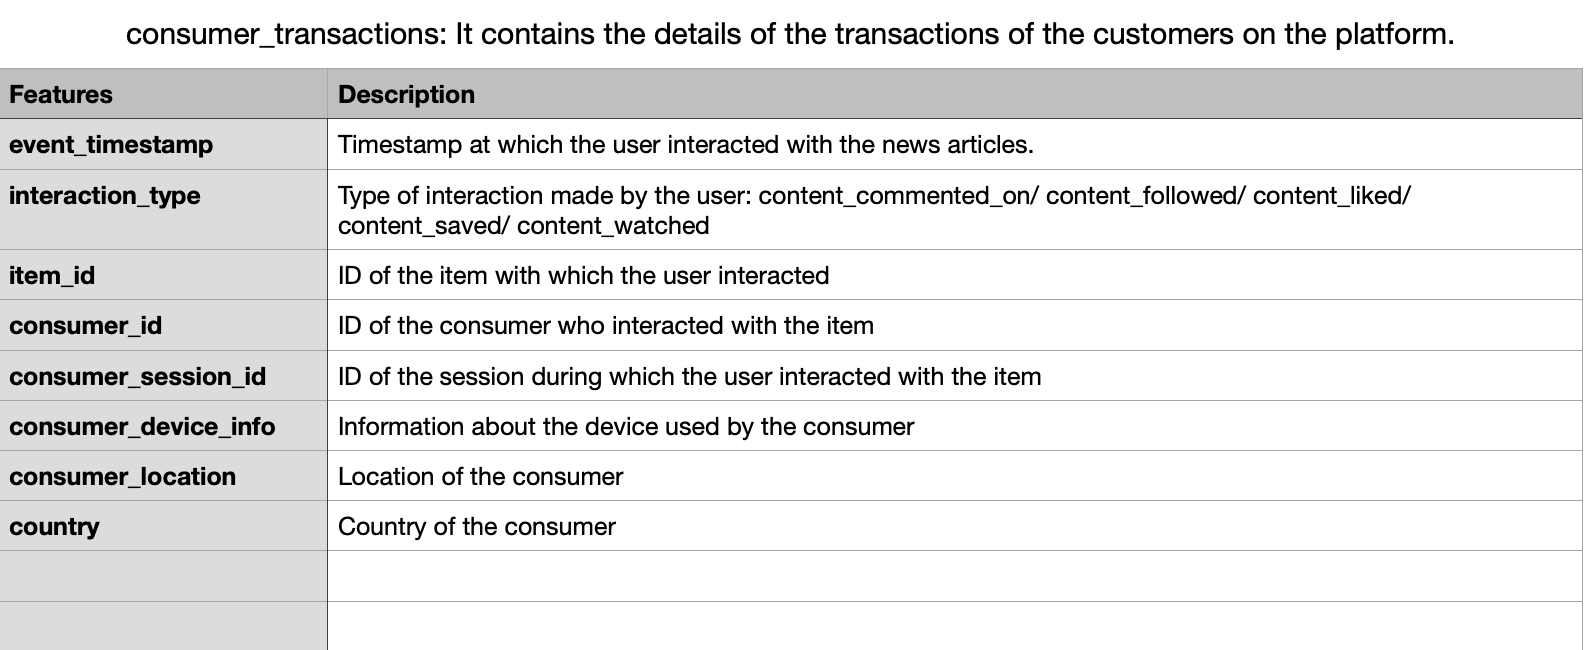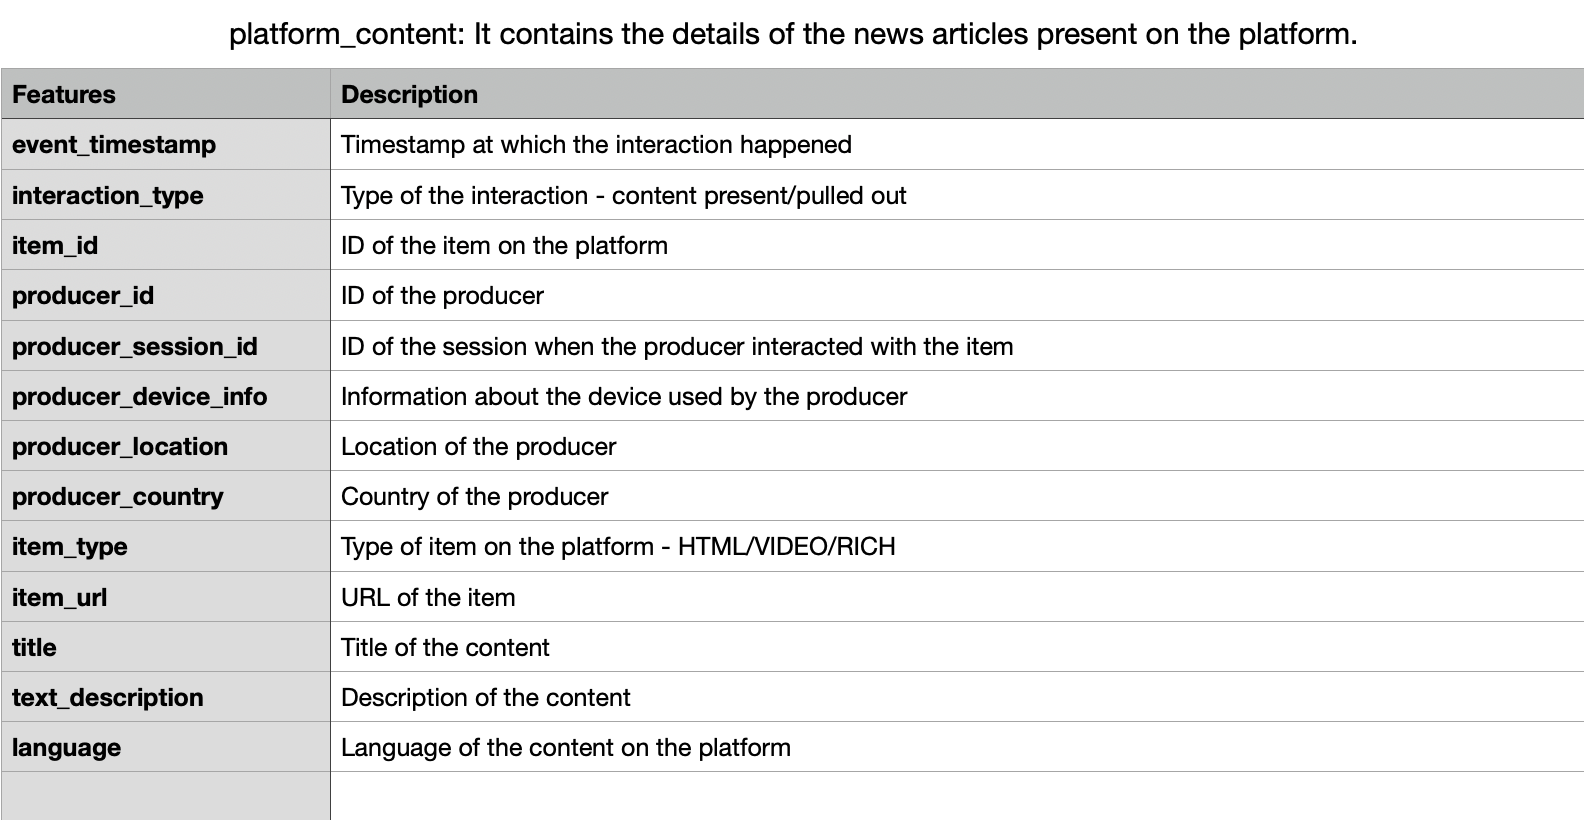



In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/gdrive"     # default location for the drive
drive.mount(ROOT)           # we mount the google drive at /content/drive

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Colab Notebooks/Capstone/NewsRecommendor

/content/gdrive/MyDrive/Colab Notebooks/Capstone/NewsRecommendor


In [3]:
!pwd

/content/gdrive/MyDrive/Colab Notebooks/Capstone/NewsRecommendor


In [4]:
#importing Numpy and panda
import pandas as pd
import numpy as np

In [5]:
#importing two CSV.
con_trans = pd.read_csv('data/consumer_transanctions.csv')
plat_con = pd.read_csv('data/platform_content.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
con_trans.shape

(72312, 8)

In [7]:
plat_con.shape

(3122, 13)

In [8]:
con_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       72312 non-null  int64 
 1   interaction_type      72312 non-null  object
 2   item_id               72312 non-null  int64 
 3   consumer_id           72312 non-null  int64 
 4   consumer_session_id   72312 non-null  object
 5   consumer_device_info  56918 non-null  object
 6   consumer_location     56907 non-null  object
 7   country               56918 non-null  object
dtypes: int64(3), object(5)
memory usage: 4.4+ MB


In [9]:
con_trans.head(5)

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN


we can see that few of item_id and consumer_id are negative, so let's explore that!

In [14]:
con_trans['abs_id'] = abs(con_trans.consumer_id)

In [18]:
#since taking absolute of the ID doesnt change the no of unique values, let's drop change consumer_id

print(con_trans['consumer_id'].nunique())
print(con_trans['abs_id'].nunique())

1895
1895


In [19]:
con_trans['consumer_id'] = abs(con_trans.consumer_id)
con_trans.drop('abs_id', axis = 1, inplace= True)

In [22]:
#checking to see if unique values of item_id changes with absolute value. 
print(con_trans['item_id'].nunique())
con_trans['item_id'] = abs(con_trans.item_id)
print(con_trans['item_id'].nunique())

2987
2987


In [23]:
plat_con.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       3122 non-null   int64 
 1   interaction_type      3122 non-null   object
 2   item_id               3122 non-null   int64 
 3   producer_id           3122 non-null   int64 
 4   producer_session_id   3122 non-null   int64 
 5   producer_device_info  680 non-null    object
 6   producer_location     680 non-null    object
 7   producer_country      680 non-null    object
 8   item_type             3122 non-null   object
 9   item_url              3122 non-null   object
 10  title                 3122 non-null   object
 11  text_description      3122 non-null   object
 12  language              3122 non-null   object
dtypes: int64(4), object(9)
memory usage: 317.2+ KB


In [24]:
plat_con.head(5)

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


We can see that few of item_id and producer_id are negative, so let's explore that!

In [27]:
#checking to see if unique values of item_id changes with absolute value. 
print(plat_con['item_id'].nunique())
plat_con['item_id'] = abs(plat_con.item_id)
print(plat_con['item_id'].nunique())

3057
3057


In [28]:
#checking to see if unique values of producer_id changes with absolute value. 
print(plat_con['producer_id'].nunique())
plat_con['producer_id'] = abs(plat_con.producer_id)
print(plat_con['producer_id'].nunique())

252
252


> Note: taking absolute of the id quantities doesnt change the number of distinct values, hence is a successful way to handle the negative values of all four id featuress in the two dataset.


Importing Basic Libraries!

In [ ]:
import matplotlib.pyplot as plt

### Pre-Processing

#### Using the ‘platform_content’(plat_con) data to extract the data set that contains the English articles present on the platform and drop the language column.

In [29]:
eng_content = plat_con.loc[plat_con['language'] == 'en']

In [30]:
#to check if the above action did it's job!
eng_content['language'].value_counts()

en    2264
Name: language, dtype: int64

In [31]:
#drop language column. 
eng_content.drop('language', axis = 1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### On the dataset Consumer Transaction (con_trans), Let's impute the rating values based on the feature-map given below:


1.   content_watched
2.   content_liked
3.   content_saved
4.   content_commented_on
5.   content_followed

also, we can drop interaction_type as it is coded in rating.


In [32]:
#checking the spread of the 'interaction_type' categorical variable in con_trans
print(con_trans['interaction_type'].value_counts())

content_watched         61086
content_liked            5745
content_saved            2463
content_commented_on     1611
content_followed         1407
Name: interaction_type, dtype: int64


In [33]:
#mapping 
con_trans['rating'] = con_trans.interaction_type.map({'content_watched':1,'content_liked':2,'content_saved':3,'content_commented_on':4,'content_followed':5})

In [34]:
#checking the mapped rating values
print(con_trans['rating'].value_counts())

1    61086
2     5745
3     2463
4     1611
5     1407
Name: rating, dtype: int64


In [35]:
#drop interaction_type column. 
con_trans.drop('interaction_type', axis = 1, inplace=True)

#### Let's check the null values now in **consumer transaction** file! (con_trans)

In [36]:
print(round(100*(con_trans.isnull().sum()/len(con_trans.index)), 2).sort_values(ascending=False))

consumer_location       21.30
country                 21.29
consumer_device_info    21.29
rating                   0.00
consumer_session_id      0.00
consumer_id              0.00
item_id                  0.00
event_timestamp          0.00
dtype: float64


> Let's Explore more on this dataset in the EDA part. We can decide on how to handle nulls values there. 

#### Let's check the null values now in **platform content** file! (eng_content)

In [39]:
eng_content.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2264 entries, 0 to 3121
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       2264 non-null   int64 
 1   interaction_type      2264 non-null   object
 2   item_id               2264 non-null   int64 
 3   producer_id           2264 non-null   int64 
 4   producer_session_id   2264 non-null   int64 
 5   producer_device_info  473 non-null    object
 6   producer_location     473 non-null    object
 7   producer_country      473 non-null    object
 8   item_type             2264 non-null   object
 9   item_url              2264 non-null   object
 10  title                 2264 non-null   object
 11  text_description      2264 non-null   object
dtypes: int64(4), object(8)
memory usage: 229.9+ KB


In [40]:
print(round(100*(eng_content.isnull().sum()/len(eng_content.index)), 2).sort_values(ascending=False))

producer_country        79.11
producer_location       79.11
producer_device_info    79.11
text_description         0.00
title                    0.00
item_url                 0.00
item_type                0.00
producer_session_id      0.00
producer_id              0.00
item_id                  0.00
interaction_type         0.00
event_timestamp          0.00
dtype: float64


In [41]:
print(eng_content['producer_device_info'].nunique())

96


To handle almost 80% of missing values is difficult. Hence we will drop: producer_country, producer_location and producer_device_info as they hold no value in which way in the EDA being a description about content.

In [42]:
eng_content.drop(['producer_device_info', 'producer_country', 'producer_location'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [44]:
#final set so far.
print(round(100*(eng_content.isnull().sum()/len(eng_content.index)), 2).sort_values(ascending=False))

text_description       0.0
title                  0.0
item_url               0.0
item_type              0.0
producer_session_id    0.0
producer_id            0.0
item_id                0.0
interaction_type       0.0
event_timestamp        0.0
dtype: float64


### Exploratory Data Analysis

* Explore the various features present in the data set for their distribution and any meaningful inferences.
* Check the distribution of interaction type, consumer location/country, producer country/location, item type and so on.
* Check the most common language and most popular country that consumes the articles on the platform.


#### For consumer transaction file! (con_trans)

### Model Building!

#### User-based collaborative filtering
* Create user-item matrix using the rating values.
* Find the user-similarity matrix based on a similarity measure.
* Generate predicted ratings for all the user-item pairs.
> Data set- ‘consumer_interaction’



#### Item-based collaborative filtering
* Find the item-similarity matrix based on a similarity measure.
* Generate the top 10 similar and relevant items based on the similarity scores.
> Data set- ‘consumer_interaction’

#### ALS
* Create Compressed Sparse user-item and item-user matrices. 
* Train the ALS model and generate recommendations for a user. Try experimenting with the hyperparameters.
> Data set- ‘consumer_interaction’

#### Hybrid recommendation system
* Normalise the scores for content and collaborative filtering and combine them with an appropriate weightage to build a hybrid model.
* Try out hybrids of different types of models that can help recommend items similar to a particular item. For example, Content+Item-based collaborative model, ALS+Item-based collaborative model, ALS+Content-based model, etc.
> Data set- ‘platform_content’ - to build a content-based recommendation model.